### Chain Using LangGraph
In this section we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

In [64]:
from dotenv import load_dotenv
load_dotenv()

import os
# os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)



In [65]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="VaibhaV"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="VaibhaV"))

for message in messages:
    message.pretty_print()
    # print(message)



================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: VaibhaV

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: VaibhaV

I want to learn python programming language


### Chat Models

We can use the sequence of message as input with the chatmodels using LLM's and OPENAI.

In [66]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-20b")
result=llm.invoke(messages)

In [67]:
result.pretty_print()

================================== Ai Message ==================================

Great! Python is an excellent first language—readable, versatile, and widely used in everything from web development to data science, AI, automation, and even game development.  
Below is a **step‑by‑step learning path** that balances theory, hands‑on practice, and real‑world projects. Feel free to skip ahead or linger on a topic that interests you most.

---

## 1️⃣ Why Python?

| Feature | Why It Matters |
|--------|---------------|
| **Readable syntax** | “Code like English.” Easier to debug and maintain. |
| **Large ecosystem** | `requests`, `numpy`, `pandas`, `flask`, `django`, `pygame`, etc. |
| **Community support** | Thousands of tutorials, forums, and open‑source libraries. |
| **Career demand** | Top 10 languages on Stack Overflow, LinkedIn, and job boards. |

---

## 2️⃣ Quick Setup

| Platform | Recommended Tool |
|---------|-----------------|
| Windows | VS Code + Python extension + `venv` |


In [68]:
result.response_metadata

{'token_usage': {'completion_tokens': 1551,
  'prompt_tokens': 113,
  'total_tokens': 1664,
  'completion_time': 1.2887424379999999,
  'prompt_time': 0.007810598,
  'queue_time': 0.045132569,
  'total_time': 1.296553036},
 'model_name': 'openai/gpt-oss-20b',
 'system_fingerprint': 'fp_fd68d84dd3',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

In [69]:
def add(a:int,b:int)-> int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a+b

In [70]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10eeb7850>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10eeaa710>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [71]:
### Binding tool with llm

llm_with_tools=llm.bind_tools([add])

tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2",name="VaibhaV")])

In [72]:
tool_call

AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to use the add function.', 'tool_calls': [{'id': 'fc_324af9b3-568c-4e5a-b5cb-043b71d1d778', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 148, 'total_tokens': 183, 'completion_time': 0.029103903, 'prompt_time': 0.00977244, 'queue_time': 0.043866947, 'total_time': 0.038876343}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_fd68d84dd3', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6177984e-b782-4bd6-9774-c0f10ea28ff4-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'fc_324af9b3-568c-4e5a-b5cb-043b71d1d778', 'type': 'tool_call'}], usage_metadata={'input_tokens': 148, 'output_tokens': 35, 'total_tokens': 183})

In [73]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'fc_324af9b3-568c-4e5a-b5cb-043b71d1d778',
  'type': 'tool_call'}]

### Using messages as state

In [74]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    message:list[AnyMessage]

#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [75]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

### Reducers with add_messages

In [76]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="VaibhaV"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='VaibhaV')]

In [77]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [78]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='cbfaac27-98b4-40fe-aedf-54184b9be096'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='VaibhaV', id='bc79686b-d202-4358-883f-e36a5744f4b3'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='2177c41e-ca99-4d1e-8970-5502b4317ea8')]

In [79]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

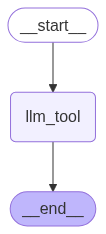

In [80]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [81]:
## invocation

messages=graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (fc_1cea2a0b-df30-4ed1-a978-398e04f4090c)
 Call ID: fc_1cea2a0b-df30-4ed1-a978-398e04f4090c
  Args:
    a: 2
    b: 2


In [60]:
tools=[add]

In [82]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder=StateGraph(State)

## Add nodes

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)


graph_builder = builder.compile()



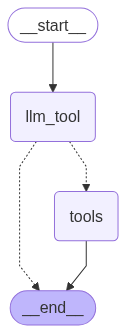

In [84]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [86]:
## invocation

messages=graph_builder.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (fc_f1125bc8-5935-44bc-8929-6e6460ca7f5e)
 Call ID: fc_f1125bc8-5935-44bc-8929-6e6460ca7f5e
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [87]:
messages=graph_builder.invoke({"messages":"What Machine Learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What Machine Learning
================================== Ai Message ==================================

**Machine Learning (ML)** is a subfield of artificial intelligence (AI) that focuses on building systems that can learn from data, identify patterns, and make decisions or predictions without being explicitly programmed for each specific task.

---

## 1. Core Idea

- **Learning from Data**  
  Instead of hard‑coding rules, ML models ingest large amounts of data (examples, features) and automatically discover relationships or patterns that explain the data.

- **Generalization**  
  Once trained, the model can apply what it has learned to new, unseen data—often with impressive accuracy.

---

## 2. Key Concepts

| Concept | What it is | Why it matters |
|--------|-----------|---------------|
| **Feature** | A measurable attribute of the data (e.g., pixel intensity, word frequency). | The raw input that 

In [89]:
messages=graph_builder.invoke({"messages":"What 2 plus 3 plus 4"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What 2 plus 3 plus 4
================================== Ai Message ==================================

2 + 3 + 4 = 9.
